In [1]:
import glob

In [2]:
good_images = glob.glob("/root/data/lice-data/crops/blom-kjeppevikholmen/*/2/*.jpg")
print("Number of good images {}".format(len(good_images)))
bad_images = glob.glob("/root/data/priority_queue/images/*/*.jpg")
print("Number of bad images {}".format(len(bad_images)))

Number of good images 10368
Number of bad images 22852


Load some annotations

In [3]:
import json
import os

In [4]:
image_classes = json.load(open("/root/data/priority_queue/images/image_classes.json"))

In [5]:
# for (k,v) in image_classes.items():
#     print(v)
#     print([int(k) for k in v])
#     break

In [6]:
for img in bad_images:
    name = os.path.basename(img)
    if name not in image_classes:
        print("red alert")

Create generator

Experiences:
* BW classifier
* RGB classifer: overfitting done / 
* split per class with sigmoid head

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [8]:
import random
random.seed(124)
random.shuffle(bad_images)
random.shuffle(good_images)

In [9]:
cutoff_good = int(len(good_images)*0.8)
cutoff_bad = int(len(bad_images)*0.8)

train_good = good_images[:cutoff_good]
val_good = good_images[cutoff_good:]

train_bad = bad_images[:cutoff_bad]
val_bad = bad_images[cutoff_bad:]

In [10]:
ngpus = 2
new_shape = (224, 224)
batch_size = 32*ngpus
classes = 5

In [11]:
import keras

Using TensorFlow backend.


In [12]:
from imgaug import augmenters as iaa

In [13]:
augmenters = {1: iaa.GaussianBlur((0.0, 3.0), name="GaussianBlur"),
              2: iaa.Add((-100, 0))}
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

In [14]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, good_images, bad_images, batch_size=batch_size, dim=(224, 224, 3)):
        'Initialization'
        self.good_images = good_images
        self.batch_size = batch_size
        self.bad_images = bad_images
        self.dim = dim
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int((len(self.good_images) + len(self.bad_images)) / self.batch_size)
    
    def __getitem__(self, index):
        'Generate one batch of data'
        xbatch = []
        ybatch = []
        for i in range(self.batch_size):
            if i % 2 == 0:
                path = np.random.choice(self.good_images)
                label = [1, 0, 0, 0, 0]
            else:
                path = np.random.choice(self.bad_images)
                tmp = image_classes[os.path.basename(path)]
                label = [0] + [int(k) if k is not None else 0 for k in tmp]
                
            auglist = []
            for i in range(len(label)):
                if label[i] and i in augmenters:
                    auglist.append(sometimes(augmenters[i]))
            if len(auglist) > 0:
                seq = iaa.Sequential(auglist)
            else:
                seq = None
                
            image = cv2.imread(path)
            image = cv2.resize(image, new_shape)
            if seq:
                image = seq.augment_image(image)
            xbatch.append(image)
            ybatch.append(label)

        return np.array(xbatch), np.array(ybatch)
    
    def on_epoch_end(self):
        random.shuffle(self.good_images)
        random.shuffle(self.bad_images)

In [15]:
traingen = DataGenerator(train_good, train_bad)
valgen = DataGenerator(val_good, val_bad)

In [16]:
xb, yb = traingen[0]

In [17]:
print(xb.shape, yb.shape)

(64, 224, 224, 3) (64, 5)


In [18]:
# for i in range(batch_size):
#     plt.imshow(xb[i, ...])
#     plt.show()
#     print(yb[i])
#     if yb[i] == 1:
#         print("good")
#     else:
#         print("bad")

load and compile model

In [19]:
import os

from keras import layers
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet import MobileNet
from keras.optimizers import Adam
from keras.utils import multi_gpu_model
import tensorflow as tf

In [20]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Models:
* resnet50 = overfit
* mobilenet 
    

In [21]:
# body = ResNet50(include_top=False, 
#                  weights='imagenet',
#                  input_shape=(256, 256, 3),
#                  pooling="avg")
# x = body.output
# x = layers.Dense(1, activation='sigmoid', name='fc1000')(x)

In [22]:
with tf.device('/cpu:0'):
    alpha=1.0
    shape = (1, 1, int(1024 * alpha))
    dropout=1e-3
    body = MobileNet(include_top=False,
                     weights='imagenet',
                     input_shape=(224, 224, 3),
                     pooling=None
                    )
    
    x = layers.GlobalAveragePooling2D()(body.output)
    x = layers.Reshape(shape, name='reshape_1')(x)
    x = layers.Dropout(dropout, name='dropout')(x)
    x = layers.Conv2D(classes, (1, 1),
                      padding='same',
                      name='conv_preds')(x)
    x = layers.Activation('sigmoid', name='act_sigmoid')(x)
    x = layers.Reshape((classes,), name='reshape_2')(x)
    
    single_model = Model([body.input], [x])

In [23]:
model = multi_gpu_model(single_model, gpus=ngpus)

In [24]:
adam = Adam()

In [25]:
model.compile(adam, loss="binary_crossentropy", metrics=["binary_accuracy"])

train

In [26]:
slowdown = 5

In [27]:
history = model.fit_generator(generator = traingen, 
                              steps_per_epoch=(len(train_good) + len(train_bad))//(batch_size*slowdown),
                              workers=10,
                              max_queue_size=20,
                              use_multiprocessing=False,
                              validation_data=valgen,
                              validation_steps = (len(val_good) + len(val_bad))//batch_size,
                              epochs=4*slowdown)

Epoch 1/20
83/83 [==============================] - 61s 740ms/step - loss: 0.2735 - binary_accuracy: 0.8794 - val_loss: 0.3200 - val_binary_accuracy: 0.8899
Epoch 2/20
83/83 [==============================] - 50s 605ms/step - loss: 0.2211 - binary_accuracy: 0.9064 - val_loss: 0.3769 - val_binary_accuracy: 0.8628
Epoch 3/20
83/83 [==============================] - 51s 617ms/step - loss: 0.1865 - binary_accuracy: 0.9221 - val_loss: 0.3202 - val_binary_accuracy: 0.8727
Epoch 4/20
83/83 [==============================] - 50s 605ms/step - loss: 0.1765 - binary_accuracy: 0.9262 - val_loss: 0.3275 - val_binary_accuracy: 0.8957
Epoch 5/20
83/83 [==============================] - 52s 624ms/step - loss: 0.1776 - binary_accuracy: 0.9265 - val_loss: 0.3107 - val_binary_accuracy: 0.9006
Epoch 6/20
83/83 [==============================] - 55s 663ms/step - loss: 0.1650 - binary_accuracy: 0.9335 - val_loss: 0.3535 - val_binary_accuracy: 0.8893
Epoch 7/20
83/83 [==============================] - 55s 66

In [28]:
h = history.history

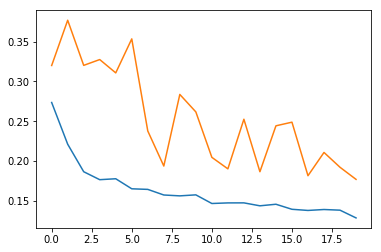

In [29]:
plt.plot(h["loss"])
plt.plot(h["val_loss"])
plt.show()

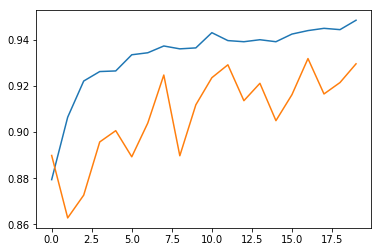

In [30]:
plt.plot(h["binary_accuracy"])
plt.plot(h["val_binary_accuracy"])
plt.show()

In [31]:
single_model.save("/root/data/priority_queue/models/draft_5.h5")